# CatBoost Model - Housing Price Prediction

Model du doan gia nha dat su dung CatBoost voi:
- Cross-validation tren tap train
- Optuna hyperparameter tuning
- Danh gia dua tren nhieu metrics

In [1]:
# Import thu vien can thiet
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    mean_absolute_percentage_error
)
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

# Cau hinh duong dan
BASE_DIR = Path("..").resolve()
DATA_DIR = BASE_DIR / "data"
MODEL_DIR = BASE_DIR / "models" / "catboost"

# Tao thu muc luu model neu chua ton tai
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Model directory: {MODEL_DIR}")

Base directory: D:\DUT_AI\Project\PredictHousing
Data directory: D:\DUT_AI\Project\PredictHousing\data
Model directory: D:\DUT_AI\Project\PredictHousing\models\catboost


## 1. Load va Xu ly Du lieu

In [2]:
# Load du lieu train va test
train_df = pd.read_csv(DATA_DIR / "train_data.csv")
test_df = pd.read_csv(DATA_DIR / "test_data.csv")

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nCac cot trong du lieu:")
print(train_df.columns.tolist())

Train shape: (4773, 19)
Test shape: (1194, 19)

Cac cot trong du lieu:
['Diện tích (m2)', 'Hướng', 'Chiều ngang (m)', 'Chiều dài (m)', 'Số phòng ngủ', 'Số phòng vệ sinh', 'Số tầng', 'Tình trạng nội thất', 'Tổng_phòng', 'Aspect_ratio', 'Diện_tích_per_phòng', 'Thành phố_encoded', 'Phường/Xã_encoded', 'Loại hình_Nhà biệt thự', 'Loại hình_Nhà mặt phố, mặt tiền', 'Loại hình_Nhà ngõ, hẻm', 'Loại hình_Nhà phố liền kề', 'Giấy tờ pháp lý_encoded', 'Giá']


In [3]:
# Kiem tra kieu du lieu cua cac cot
print("Kieu du lieu cac cot:")
print(train_df.dtypes)
print(f"\nCac cot bool: {train_df.select_dtypes(include=['bool']).columns.tolist()}")
print(f"Cac cot object (category): {train_df.select_dtypes(include=['object']).columns.tolist()}")

Kieu du lieu cac cot:
Diện tích (m2)                     float64
Hướng                               object
Chiều ngang (m)                    float64
Chiều dài (m)                      float64
Số phòng ngủ                       float64
Số phòng vệ sinh                   float64
Số tầng                            float64
Tình trạng nội thất                 object
Tổng_phòng                           int64
Aspect_ratio                       float64
Diện_tích_per_phòng                float64
Thành phố_encoded                  float64
Phường/Xã_encoded                  float64
Loại hình_Nhà biệt thự                bool
Loại hình_Nhà mặt phố, mặt tiền       bool
Loại hình_Nhà ngõ, hẻm                bool
Loại hình_Nhà phố liền kề             bool
Giấy tờ pháp lý_encoded              int64
Giá                                float64
dtype: object

Cac cot bool: ['Loại hình_Nhà biệt thự', 'Loại hình_Nhà mặt phố, mặt tiền', 'Loại hình_Nhà ngõ, hẻm', 'Loại hình_Nhà phố liền kề']
Cac cot object 

In [4]:
def preprocess_data(df):
    """
    Xu ly du lieu:
    - Chuyen cot bool sang int
    - Giu nguyen cot object de CatBoost tu xu ly
    """
    df = df.copy()
        
    # Chuyen cac cot bool sang int
    bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
    for col in bool_cols:
        df[col] = df[col].astype(int)
    print(f"Da chuyen {len(bool_cols)} cot bool sang int: {bool_cols}")
    
    return df

# Ap dung xu ly cho train va test
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

print(f"\nTrain shape sau xu ly: {train_df.shape}")
print(f"Test shape sau xu ly: {test_df.shape}")

Da chuyen 4 cot bool sang int: ['Loại hình_Nhà biệt thự', 'Loại hình_Nhà mặt phố, mặt tiền', 'Loại hình_Nhà ngõ, hẻm', 'Loại hình_Nhà phố liền kề']
Da chuyen 4 cot bool sang int: ['Loại hình_Nhà biệt thự', 'Loại hình_Nhà mặt phố, mặt tiền', 'Loại hình_Nhà ngõ, hẻm', 'Loại hình_Nhà phố liền kề']

Train shape sau xu ly: (4773, 19)
Test shape sau xu ly: (1194, 19)


In [5]:
# Tach features va target
TARGET_COL = 'Giá'

X_train = train_df.drop(columns=[TARGET_COL])
y_train = train_df[TARGET_COL]

X_test = test_df.drop(columns=[TARGET_COL])
y_test = test_df[TARGET_COL]

# Xac dinh cac cot categorical (object type)
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
cat_feature_indices = [X_train.columns.get_loc(col) for col in cat_features]

print(f"Feature count: {X_train.shape[1]}")
print(f"Categorical features: {cat_features}")
print(f"Categorical feature indices: {cat_feature_indices}")
print(f"\nTrain samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Feature count: 18
Categorical features: ['Hướng', 'Tình trạng nội thất']
Categorical feature indices: [1, 7]

Train samples: 4773
Test samples: 1194


## 2. Cau hinh Train

In [6]:
# Cau hinh train - Chon CPU hoac GPU
# Doi DEVICE = "GPU" neu co GPU CUDA

DEVICE = "CPU"  # Options: "CPU" hoac "GPU"

# Cau hinh cross-validation
N_FOLDS = 5
RANDOM_STATE = 42

# Cau hinh Optuna
N_TRIALS = 200  # So luong trials cho hyperparameter tuning
OPTUNA_TIMEOUT = None  # Gioi han thoi gian (seconds), None = khong gioi han

# Vi GPU khong the chay nhieu trials song song (conflict device)
# Chi dung N_JOBS = -1 khi DEVICE = "CPU"
N_JOBS = 1 if DEVICE == "GPU" else -1

print(f"Device: {DEVICE}")
print(f"Cross-validation folds: {N_FOLDS}")
print(f"N_JOBS: {N_JOBS} {'(GPU bat buoc chay tuan tu)' if DEVICE == 'GPU' else '(CPU chay song song)'}")

Device: CPU
Cross-validation folds: 5
N_JOBS: -1 (CPU chay song song)


## 3. Optuna Hyperparameter Tuning

In [7]:
def objective(trial):
    """
    Ham objective cho Optuna tim kiem hyperparameters toi uu
    Su dung cross-validation voi R2 score (maximize)
    """
    # Hyperparameters search space
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        
        # Co dinh params
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': RANDOM_STATE,
        'verbose': 0,
        'task_type': DEVICE,
        'cat_features': cat_feature_indices,
    }
    
    # Cross-validation
    kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    rmse_scores = []
    r2_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        X_fold_train = X_train.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        # Tao Pool cho CatBoost
        train_pool = Pool(X_fold_train, y_fold_train, cat_features=cat_feature_indices)
        val_pool = Pool(X_fold_val, y_fold_val, cat_features=cat_feature_indices)
        
        # Train model
        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=0)
        
        # Predict va tinh metrics
        y_pred = model.predict(X_fold_val)
        rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))
        r2 = r2_score(y_fold_val, y_pred)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
    
    # Tra ve R2 trung binh (maximize)
    mean_rmse = np.mean(rmse_scores)
    mean_r2 = np.mean(r2_scores)
    
    # Luu ca 2 metrics vao trial user_attrs de hien thi sau
    trial.set_user_attr('mean_r2', mean_r2)
    trial.set_user_attr('mean_rmse', mean_rmse)
    
    return mean_r2  # Toi uu hoa R2 (maximize)

print("Objective function da san sang (R2 metric - maximize)")

Objective function da san sang (R2 metric - maximize)


In [8]:
# Callback hien thi ca R2 va RMSE cho tung trial
def trial_callback(study, trial):
    """Callback hien thi metrics sau moi trial"""
    r2 = trial.value
    rmse = trial.user_attrs.get('mean_rmse', 'N/A')
    if isinstance(rmse, float):
        print(f"Trial {trial.number}: R2 = {r2:.6f}, RMSE = {rmse:.6f}")
    
# Chay Optuna optimization
# Toi uu hoa R2 score (maximize)
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Giam log mac dinh

study = optuna.create_study(
    direction='maximize',  # Maximize R2 score
    sampler=TPESampler(seed=RANDOM_STATE),
    study_name='catboost_housing_price'
)

print(f"Bat dau Optuna hyperparameter tuning...")
print(f"Trials: {N_TRIALS}, Folds: {N_FOLDS}, Device: {DEVICE}")
print(f"Metric: R2 Score (maximize)")
print(f"Mode: {'Tuan tu (n_jobs=1)' if N_JOBS == 1 else f'Song song (n_jobs={N_JOBS})'}")
print("-" * 60)

study.optimize(
    objective, 
    n_trials=N_TRIALS, 
    timeout=OPTUNA_TIMEOUT,
    n_jobs=N_JOBS,
    show_progress_bar=True,
    callbacks=[trial_callback] if N_JOBS == 1 else None  # Callback chi hoat dong khi n_jobs=1
)

print("-" * 60)
# Hien thi best trial voi R2 Score
best_trial = study.best_trial
best_r2 = best_trial.value

print(f"\nBest Trial: #{best_trial.number}")
print(f"  Best R2 Score: {best_r2:.6f}")
print(f"\nBest Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

Bat dau Optuna hyperparameter tuning...
Trials: 200, Folds: 5, Device: CPU
Metric: R2 Score (maximize)
Mode: Song song (n_jobs=-1)
------------------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

------------------------------------------------------------

Best Trial: #182
  Best R2 Score: 0.693420

Best Hyperparameters:
  iterations: 897
  learning_rate: 0.0567429944869965
  depth: 6
  l2_leaf_reg: 2.733149497165989
  bagging_temperature: 0.8694563496006533
  random_strength: 0.33122573433796654
  border_count: 155
  min_data_in_leaf: 49


## 4. Train Final Model voi Best Hyperparameters

In [9]:
# Tao final model voi best hyperparameters
best_params = study.best_params.copy()
best_params.update({
    'loss_function': 'RMSE',
    'eval_metric': 'R2',
    'random_seed': RANDOM_STATE,
    'task_type': DEVICE,
    'cat_features': cat_feature_indices,
    'verbose': 100,  # Hien thi moi 100 epoch
})

print("Best hyperparameters cho final model:")
for key, value in best_params.items():
    if key != 'cat_features':
        print(f"  {key}: {value}")

Best hyperparameters cho final model:
  iterations: 897
  learning_rate: 0.0567429944869965
  depth: 6
  l2_leaf_reg: 2.733149497165989
  bagging_temperature: 0.8694563496006533
  random_strength: 0.33122573433796654
  border_count: 155
  min_data_in_leaf: 49
  loss_function: RMSE
  eval_metric: R2
  random_seed: 42
  task_type: CPU
  verbose: 100


In [10]:
# Cross-validation voi final model (hien thi chi tiet tung fold)
print("=" * 70)
print("CROSS-VALIDATION VOI BEST HYPERPARAMETERS")
print("=" * 70)

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
cv_results = {
    'r2': [], 'rmse': [], 'mae': [], 'mape': []
}

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
    print(f"\n{'='*70}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*70}")
    
    X_fold_train = X_train.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    # Tao Pool
    train_pool = Pool(X_fold_train, y_fold_train, cat_features=cat_feature_indices)
    val_pool = Pool(X_fold_val, y_fold_val, cat_features=cat_feature_indices)
    
    # Train model voi verbose de theo doi epoch
    fold_model = CatBoostRegressor(**best_params)
    fold_model.fit(
        train_pool, 
        eval_set=val_pool, 
        early_stopping_rounds=50,
        use_best_model=True
    )
    
    # Predict va tinh metrics
    y_pred = fold_model.predict(X_fold_val)
    
    fold_r2 = r2_score(y_fold_val, y_pred)
    fold_rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))
    fold_mae = mean_absolute_error(y_fold_val, y_pred)
    fold_mape = mean_absolute_percentage_error(y_fold_val, y_pred) * 100
    
    cv_results['r2'].append(fold_r2)
    cv_results['rmse'].append(fold_rmse)
    cv_results['mae'].append(fold_mae)
    cv_results['mape'].append(fold_mape)
    
    print(f"\nFold {fold + 1} Results:")
    print(f"  R2 Score: {fold_r2:.6f}")
    print(f"  RMSE: {fold_rmse:.6f}")
    print(f"  MAE: {fold_mae:.6f}")
    print(f"  MAPE: {fold_mape:.2f}%")

# Tong ket cross-validation
print("\n" + "=" * 70)
print("TONG KET CROSS-VALIDATION")
print("=" * 70)
print(f"R2 Score:  {np.mean(cv_results['r2']):.6f} (+/- {np.std(cv_results['r2']):.6f})")
print(f"RMSE:      {np.mean(cv_results['rmse']):.6f} (+/- {np.std(cv_results['rmse']):.6f})")
print(f"MAE:       {np.mean(cv_results['mae']):.6f} (+/- {np.std(cv_results['mae']):.6f})")
print(f"MAPE:      {np.mean(cv_results['mape']):.2f}% (+/- {np.std(cv_results['mape']):.2f}%)")

CROSS-VALIDATION VOI BEST HYPERPARAMETERS

FOLD 1/5
0:	learn: 0.0566302	test: 0.0542325	best: 0.0542325 (0)	total: 22.2ms	remaining: 19.9s
100:	learn: 0.7317641	test: 0.6762151	best: 0.6762151 (100)	total: 3s	remaining: 23.6s
200:	learn: 0.7685031	test: 0.6889404	best: 0.6889404 (200)	total: 5.84s	remaining: 20.2s
300:	learn: 0.7967430	test: 0.6919807	best: 0.6920631 (299)	total: 8.74s	remaining: 17.3s
400:	learn: 0.8185448	test: 0.6942966	best: 0.6943746 (379)	total: 11.7s	remaining: 14.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6943746439
bestIteration = 379

Shrink model to first 380 iterations.

Fold 1 Results:
  R2 Score: 0.694375
  RMSE: 2.052791
  MAE: 1.402590
  MAPE: 31.55%

FOLD 2/5
0:	learn: 0.0567847	test: 0.0533141	best: 0.0533141 (0)	total: 21.4ms	remaining: 19.2s
100:	learn: 0.7350379	test: 0.6480044	best: 0.6480044 (100)	total: 2.75s	remaining: 21.7s
200:	learn: 0.7732230	test: 0.6626604	best: 0.6626962 (199)	total: 5.47s	remaining: 19s
300:	

In [11]:
# Train final model tren toan bo tap train
print("\n" + "=" * 70)
print("TRAIN FINAL MODEL TREN TOAN BO TAP TRAIN")
print("=" * 70)

# Tao Pool cho full training data
full_train_pool = Pool(X_train, y_train, cat_features=cat_feature_indices)

# Train final model
final_model = CatBoostRegressor(**best_params)
final_model.fit(full_train_pool)

print(f"\nFinal model da duoc train voi {len(X_train)} samples")
print(f"Best iteration: {final_model.best_iteration_}")


TRAIN FINAL MODEL TREN TOAN BO TAP TRAIN
0:	learn: 0.0562602	total: 36.4ms	remaining: 32.6s
100:	learn: 0.7246132	total: 2.79s	remaining: 22s
200:	learn: 0.7610226	total: 5.67s	remaining: 19.6s
300:	learn: 0.7892323	total: 8.38s	remaining: 16.6s
400:	learn: 0.8086485	total: 11.1s	remaining: 13.8s
500:	learn: 0.8266091	total: 13.9s	remaining: 11s
600:	learn: 0.8407638	total: 16.5s	remaining: 8.13s
700:	learn: 0.8528105	total: 19.2s	remaining: 5.38s
800:	learn: 0.8630290	total: 22s	remaining: 2.63s
896:	learn: 0.8717010	total: 24.5s	remaining: 0us

Final model da duoc train voi 4773 samples
Best iteration: None


## 5. Danh gia tren Test Set

In [12]:
# Danh gia tren test set
print("=" * 70)
print("DANH GIA TREN TEST SET (DU LIEU CHUA THAY)")
print("=" * 70)

# Predict tren test set
y_test_pred = final_model.predict(X_test)

# Tinh cac metrics
test_metrics = {
    'r2_score': r2_score(y_test, y_test_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'mae': mean_absolute_error(y_test, y_test_pred),
    'mape': mean_absolute_percentage_error(y_test, y_test_pred) * 100,
    'mse': mean_squared_error(y_test, y_test_pred),
}

# Them metric phu
test_metrics['explained_variance'] = 1 - (np.var(y_test - y_test_pred) / np.var(y_test))
test_metrics['max_error'] = np.max(np.abs(y_test - y_test_pred))
test_metrics['median_absolute_error'] = np.median(np.abs(y_test - y_test_pred))

print(f"\nTest Set Metrics:")
print(f"  R2 Score:              {test_metrics['r2_score']:.6f}")
print(f"  RMSE:                  {test_metrics['rmse']:.6f}")
print(f"  MAE:                   {test_metrics['mae']:.6f}")
print(f"  MAPE:                  {test_metrics['mape']:.2f}%")
print(f"  MSE:                   {test_metrics['mse']:.6f}")
print(f"  Explained Variance:    {test_metrics['explained_variance']:.6f}")
print(f"  Max Error:             {test_metrics['max_error']:.6f}")
print(f"  Median Absolute Error: {test_metrics['median_absolute_error']:.6f}")

DANH GIA TREN TEST SET (DU LIEU CHUA THAY)

Test Set Metrics:
  R2 Score:              0.691108
  RMSE:                  2.054174
  MAE:                   1.345370
  MAPE:                  29.00%
  MSE:                   4.219630
  Explained Variance:    0.691144
  Max Error:             13.232719
  Median Absolute Error: 0.889080


## 6. Feature Importance

Feature Importance (Top 15):
----------------------------------------
Phường/Xã_encoded                       : 21.0896
Diện tích (m2)                          : 12.9800
Thành phố_encoded                       : 12.8428
Số phòng vệ sinh                        : 9.7451
Tổng_phòng                              : 7.5290
Chiều dài (m)                           : 5.4234
Số tầng                                 : 5.0754
Loại hình_Nhà mặt phố, mặt tiền         : 4.1844
Diện_tích_per_phòng                     : 3.9360
Chiều ngang (m)                         : 3.9194
Aspect_ratio                            : 3.3294
Loại hình_Nhà ngõ, hẻm                  : 2.9062
Tình trạng nội thất                     : 1.9153
Giấy tờ pháp lý_encoded                 : 1.5985
Hướng                                   : 1.4830


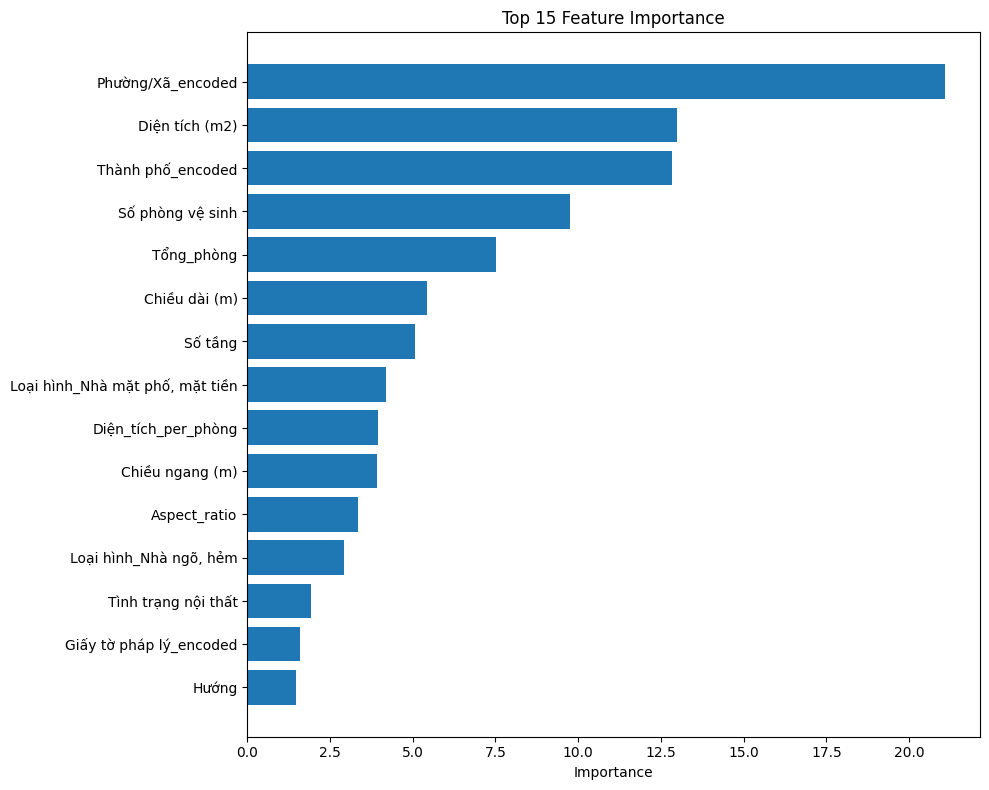

In [13]:
# Lay feature importance
feature_importance = final_model.get_feature_importance()
feature_names = X_train.columns.tolist()

# Sap xep theo importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature Importance (Top 15):")
print("-" * 40)
for idx, row in importance_df.head(15).iterrows():
    print(f"{row['feature']:40s}: {row['importance']:.4f}")

# Hien thi bieu do
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'].head(15)[::-1], importance_df['importance'].head(15)[::-1])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.show()

## 7. Luu Model va Ket qua

In [14]:
# Luu model CatBoost
model_path = MODEL_DIR / "catboost_model.cbm"
final_model.save_model(str(model_path))
print(f"Model da duoc luu tai: {model_path}")

# Luu feature names
feature_names_path = MODEL_DIR / "feature_names.json"
feature_names_data = {
    'feature_names': feature_names,
    'categorical_features': cat_features,
    'categorical_feature_indices': cat_feature_indices,
    'target_column': TARGET_COL
}
with open(feature_names_path, 'w', encoding='utf-8') as f:
    json.dump(feature_names_data, f, ensure_ascii=False, indent=2)
print(f"Feature names da duoc luu tai: {feature_names_path}")

# Luu metrics
metrics_path = MODEL_DIR / "metrics.json"
all_metrics = {
    'test_metrics': test_metrics,
    'cv_metrics': {
        'r2_mean': float(np.mean(cv_results['r2'])),
        'r2_std': float(np.std(cv_results['r2'])),
        'rmse_mean': float(np.mean(cv_results['rmse'])),
        'rmse_std': float(np.std(cv_results['rmse'])),
        'mae_mean': float(np.mean(cv_results['mae'])),
        'mae_std': float(np.std(cv_results['mae'])),
        'mape_mean': float(np.mean(cv_results['mape'])),
        'mape_std': float(np.std(cv_results['mape'])),
    },
    'best_optuna_r2': float(study.best_value),
    'n_folds': N_FOLDS,
    'n_trials': N_TRIALS,
    'device': DEVICE
}
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(all_metrics, f, ensure_ascii=False, indent=2)
print(f"Metrics da duoc luu tai: {metrics_path}")

# Luu best hyperparameters
hyperparams_path = MODEL_DIR / "best_hyperparameters.json"
best_params_save = {k: v for k, v in best_params.items() if k != 'cat_features'}
best_params_save['cat_features'] = cat_features  # Luu ten thay vi index
with open(hyperparams_path, 'w', encoding='utf-8') as f:
    json.dump(best_params_save, f, ensure_ascii=False, indent=2)
print(f"Best hyperparameters da duoc luu tai: {hyperparams_path}")

# Luu feature importance
importance_path = MODEL_DIR / "feature_importance.json"
importance_dict = importance_df.set_index('feature')['importance'].to_dict()
with open(importance_path, 'w', encoding='utf-8') as f:
    json.dump(importance_dict, f, ensure_ascii=False, indent=2)
print(f"Feature importance da duoc luu tai: {importance_path}")

Model da duoc luu tai: D:\DUT_AI\Project\PredictHousing\models\catboost\catboost_model.cbm
Feature names da duoc luu tai: D:\DUT_AI\Project\PredictHousing\models\catboost\feature_names.json
Metrics da duoc luu tai: D:\DUT_AI\Project\PredictHousing\models\catboost\metrics.json
Best hyperparameters da duoc luu tai: D:\DUT_AI\Project\PredictHousing\models\catboost\best_hyperparameters.json
Feature importance da duoc luu tai: D:\DUT_AI\Project\PredictHousing\models\catboost\feature_importance.json


In [15]:
# Tong ket cuoi cung
print("\n" + "=" * 70)
print("TONG KET")
print("=" * 70)
print(f"\nModel: CatBoost Regressor")
print(f"Device: {DEVICE}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {len(feature_names)}")
print(f"Categorical features: {len(cat_features)}")

print(f"\nOptuna Tuning:")
print(f"  Trials: {N_TRIALS}")
print(f"  Best CV R2: {study.best_value:.6f}")

print(f"\nCross-validation ({N_FOLDS} folds):")
print(f"  R2: {np.mean(cv_results['r2']):.6f} (+/- {np.std(cv_results['r2']):.6f})")

print(f"\nTest Set Performance:")
print(f"  R2 Score: {test_metrics['r2_score']:.6f}")
print(f"  RMSE: {test_metrics['rmse']:.6f}")
print(f"  MAE: {test_metrics['mae']:.6f}")
print(f"  MAPE: {test_metrics['mape']:.2f}%")

print(f"\nFiles da luu tai {MODEL_DIR}:")
for f in MODEL_DIR.glob("*"):
    print(f"  - {f.name}")


TONG KET

Model: CatBoost Regressor
Device: CPU
Training samples: 4773
Test samples: 1194
Features: 18
Categorical features: 2

Optuna Tuning:
  Trials: 200
  Best CV R2: 0.693420

Cross-validation (5 folds):
  R2: 0.693420 (+/- 0.014820)

Test Set Performance:
  R2 Score: 0.691108
  RMSE: 2.054174
  MAE: 1.345370
  MAPE: 29.00%

Files da luu tai D:\DUT_AI\Project\PredictHousing\models\catboost:
  - best_hyperparameters.json
  - catboost_model.cbm
  - feature_importance.json
  - feature_names.json
  - metrics.json


## 8. Load va Su dung Model (Optional)

In [16]:
# Load model da luu de su dung
def load_catboost_model(model_dir):
    """Load model va cac thong tin lien quan"""
    model_dir = Path(model_dir)
    
    # Load model
    model = CatBoostRegressor()
    model.load_model(str(model_dir / "catboost_model.cbm"))
    
    # Load feature names
    with open(model_dir / "feature_names.json", 'r', encoding='utf-8') as f:
        feature_info = json.load(f)
    
    # Load metrics
    with open(model_dir / "metrics.json", 'r', encoding='utf-8') as f:
        metrics = json.load(f)
    
    return model, feature_info, metrics

# Test load model
loaded_model, loaded_feature_info, loaded_metrics = load_catboost_model(MODEL_DIR)
print("Model loaded successfully!")
print(f"Test R2 from loaded metrics: {loaded_metrics['test_metrics']['r2_score']:.6f}")

# Test predict voi model loaded
test_pred = loaded_model.predict(X_test[:5])
print(f"\nPredictions (5 mau dau):")
for i, (pred, actual) in enumerate(zip(test_pred, y_test[:5].values)):
    print(f"  Sample {i+1}: Predicted={pred:.2f}, Actual={actual:.2f}")

Model loaded successfully!
Test R2 from loaded metrics: 0.691108

Predictions (5 mau dau):
  Sample 1: Predicted=8.54, Actual=10.25
  Sample 2: Predicted=4.16, Actual=4.00
  Sample 3: Predicted=4.71, Actual=4.68
  Sample 4: Predicted=1.38, Actual=1.55
  Sample 5: Predicted=4.80, Actual=4.70
